# Import Modules

In [1]:
import opendatasets as od
import pandas
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from glob import glob
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Load the data

In [2]:
# od.download(
#     "https://www.kaggle.com/datasets/tentotheminus9/gravity-spy-gravitational-waves/data")



In [3]:
# Paths
BASE_DIR = "gravity-spy-gravitational-waves"  # Adjust this to your dataset's root
CSV_PATH = os.path.join(BASE_DIR, "trainingset_v1d1_metadata.csv")
IMAGE_DIRS = ["train/train", "validation/validation", "test/test"]  # Dataset folders

# Load metadata CSV
metadata = pd.read_csv(CSV_PATH)

In [4]:
metadata

event_time ifo   peak_time  peak_time_ns  start_time  start_time_ns  \
0     1.134216e+09  L1  1134216192     931639909  1134216192      832031011   
1     1.129360e+09  L1  1129359781     558593034  1129359781       47851085   
2     1.127425e+09  L1  1127425468     976317882  1127425468      960937023   
3     1.132637e+09  L1  1132636755     365233898  1132636754      951172113   
4     1.132036e+09  L1  1132035853     197264909  1132035852      933837890   
...            ...  ..         ...           ...         ...            ...   
7961  1.127688e+09  L1  1127688297     710937023  1127688292              0   
7962  1.128422e+09  L1  1128421736     324218034  1128421736      304687023   
7963  1.164774e+09  H1  1164773536     433593034  1164773535      911376953   
7964  1.163790e+09  L1  1163789867     496093034  1163789867      476562023   
7965  1.166335e+09  H1  1166334944     306639909  1166334940      703125000   

      duration   search  process_id  event_id  ...  chisq_dof  param_one_name  \
0      0.18750  Omicron           0        21  ...          0           phase   
1      0.94238  Omicron           0       107  ...          0           phase   
2      0.04688  Omicron           0       218  ...          0           phase   
3      0.82422  Omicron           0        88  ...          0           phase   
4      2.00366  Omicron           0        16  ...          0           phase   
...        ...      ...         ...       ...  ...        ...             ...   
7961   9.00391  Omicron           0       182  ...          0           phase   
7962   0.03906  Omicron           0       396  ...          0           phase   
7963   1.16675  OMICRON           0      1817  ...          0           phase   
7964   0.10156  OMICRON           0       501  ...          0           phase   
7965   4.09375  OMICRON           0      4883  ...          0           phase   

      param_one_value gravityspy_id           label  sample_type  \
0            -2.72902    zmIdpucyOG         Whistle        train   
1             1.10682    zWFRqqDxwv         Whistle         test   
2            -0.83099    zKCTakFVcf         Whistle        train   
3             0.76242    z14BdoiFZS         Whistle   validation   
4            -0.31161    yyjqLCtAmO         Whistle   validation   
...               ...           ...             ...          ...   
7961         -2.48491    K4lUik19zL  Extremely_Loud        train   
7962          1.32651    EkRSkrpPet           Helix   validation   
7963          2.72929    xyLhvRKzzX       1080Lines        train   
7964          0.66486    lshKvhcRcT     Violin_Mode        train   
7965          0.48181    rVtNKB41sZ       1080Lines        train   

                                                   url1  \
0     https://panoptes-uploads.zooniverse.org/produc...   
1     https://panoptes-uploads.zooniverse.org/produc...   
2     https://panoptes-uploads.zooniverse.org/produc...   
3     https://panoptes-uploads.zooniverse.org/produc...   
4     https://panoptes-uploads.zooniverse.org/produc...   
...                                                 ...   
7961  https://panoptes-uploads.zooniverse.org/produc...   
7962  https://panoptes-uploads.zooniverse.org/produc...   
7963  https://panoptes-uploads.zooniverse.org/produc...   
7964  https://panoptes-uploads.zooniverse.org/produc...   
7965  https://panoptes-uploads.zooniverse.org/produc...   

                                                   url2  \
0     https://panoptes-uploads.zooniverse.org/produc...   
1     https://panoptes-uploads.zooniverse.org/produc...   
2     https://panoptes-uploads.zooniverse.org/produc...   
3     https://panoptes-uploads.zooniverse.org/produc...   
4     https://panoptes-uploads.zooniverse.org/produc...   
...                                                 ...   
7961  https://panoptes-uploads.zooniverse.org/produc...   
7962  https://panoptes-uploads.zooniverse.org/produc...   
7963  https://panoptes-upload

In [5]:
# Define features
all_features = ["duration", "peak_frequency", "central_freq", "bandwidth", "amplitude", "snr","label"]

# Create a DataFrame for features
X_tabular = metadata[all_features].copy()

# Encode labels (y) and store in DataFrame
label_encoder = LabelEncoder()
X_tabular["label"] = label_encoder.fit_transform(metadata["label"])

# Load images
image_size = (224, 224)  # Resize images to 128x128

In [6]:
print("Loading images...")
X_images = []
for _, row in tqdm(metadata.iterrows(), total=len(metadata), desc="Processing Images"):
    label = row["label"]
    ifo = row["ifo"]
    gravityspy_id = row["gravityspy_id"]

    image_pattern = f"{ifo}_{gravityspy_id}_spectrogram_*.png"
    image_found = False

    for folder in IMAGE_DIRS:
        image_folder = os.path.join(BASE_DIR, folder, label)

        if os.path.exists(image_folder):
            # Search for matching images
            matching_images = glob(os.path.join(image_folder, image_pattern))
            if matching_images:
                img_path = matching_images[0]  # Pick the first match
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Load image in RGB
                img = cv2.resize(img, image_size)  # Resize image
                X_images.append(img)
                image_found = True
                break

    if not image_found:
        print(f"⚠️ Image not found for {ifo}_{gravityspy_id}")
        X_images.append(np.zeros((*image_size, 3), dtype=np.uint8))  # Placeholder black RGB image

X_images = np.array(X_images, dtype=np.float32) / 255.0
print(f"\n✅ Data Loaded Successfully!")

Loading images...


Processing Images: 100%|██████████| 7966/7966 [03:43<00:00, 35.70it/s]



✅ Data Loaded Successfully!


# Data Preprocessing

In [7]:
# Final shape checks
print(f"X_images shape: {X_images.shape}")  # (num_samples, 128, 128, 3)
print(f"X_tabular shape: {X_tabular.shape}")  # (num_samples, num_features + 1 for label)

X_images shape: (7966, 224, 224, 3)
X_tabular shape: (7966, 7)


In [8]:
X_tabular

duration  peak_frequency  central_freq    bandwidth     amplitude  \
0      0.18750     1337.695312   1120.043213   573.363953  1.197650e-22   
1      0.94238      654.747681   1823.073364  3426.576416  8.255850e-23   
2      0.04688     1337.827515   2024.177490  3778.701904  9.762940e-22   
3      0.82422     1182.974609   3981.774658  7492.717773  1.462120e-22   
4      2.00366     1456.511353   3979.026855  7942.912109  4.038300e-22   
...        ...             ...           ...          ...           ...   
7961   9.00391       41.940331   1972.764160  3881.528320  2.120510e-19   
7962   0.03906      134.965424    202.500534   170.593903  5.184990e-22   
7963   1.16675     1085.830078   4001.193115  7898.579102  4.994010e-22   
7964   0.10156     1035.676880   2051.402832  2131.378662  2.744010e-22   
7965   4.09375     1082.743164   3979.047363  7942.870605  2.673990e-22   

              snr  label  
0        7.511390     21  
1        9.630130     21  
2       15.371040     21  
3       10.321160     21  
4       14.380160     21  
...           ...    ...  
7961  1033.286987      5  
7962     8.623000      6  
7963    19.424089      0  
7964     8.651070     19  
7965    11.485420      0  

[7966 rows x 7 columns]

In [9]:
X_tabular["amplitude"] = np.log1p(X_tabular["amplitude"])

In [10]:
X_tabular["freq_diff"] = X_tabular["central_freq"] - X_tabular["peak_frequency"]
X_tabular["bandwidth_ratio"] = X_tabular["bandwidth"] / X_tabular["central_freq"]

In [11]:
X_tabular.head()

duration  peak_frequency  central_freq    bandwidth     amplitude  \
0   0.18750     1337.695312   1120.043213   573.363953  1.197650e-22   
1   0.94238      654.747681   1823.073364  3426.576416  8.255850e-23   
2   0.04688     1337.827515   2024.177490  3778.701904  9.762940e-22   
3   0.82422     1182.974609   3981.774658  7492.717773  1.462120e-22   
4   2.00366     1456.511353   3979.026855  7942.912109  4.038300e-22   

        snr  label    freq_diff  bandwidth_ratio  
0   7.51139     21  -217.652100         0.511912  
1   9.63013     21  1168.325684         1.879560  
2  15.37104     21   686.349976         1.866784  
3  10.32116     21  2798.800049         1.881753  
4  14.38016     21  2522.515503         1.996195

# Data Exploration

<Axes: xlabel='central_freq', ylabel='bandwidth'>

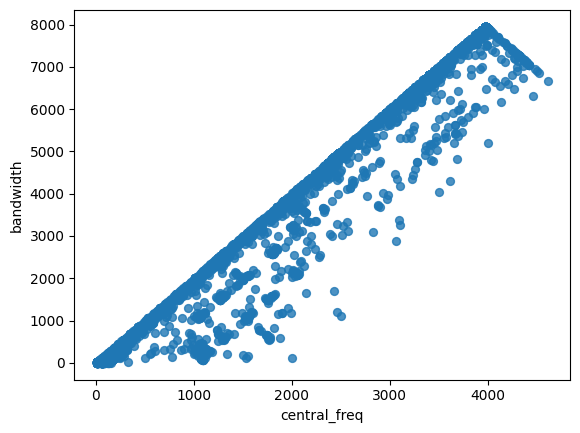

In [12]:
X_tabular.plot(kind='scatter', x='central_freq', y='bandwidth', s=32, alpha=.8)

<Axes: title={'center': 'central_freq'}, ylabel='Frequency'>

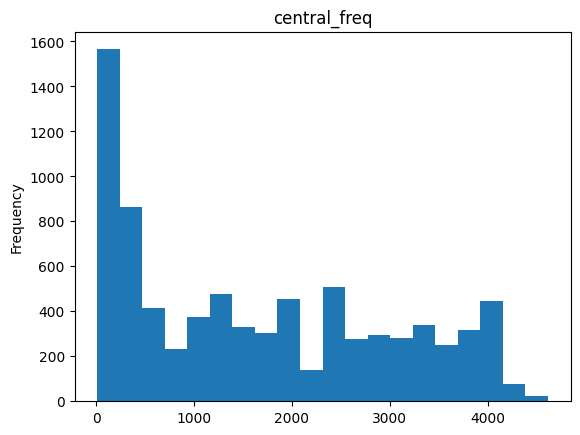

In [13]:
X_tabular['central_freq'].plot(kind='hist', bins=20, title='central_freq')

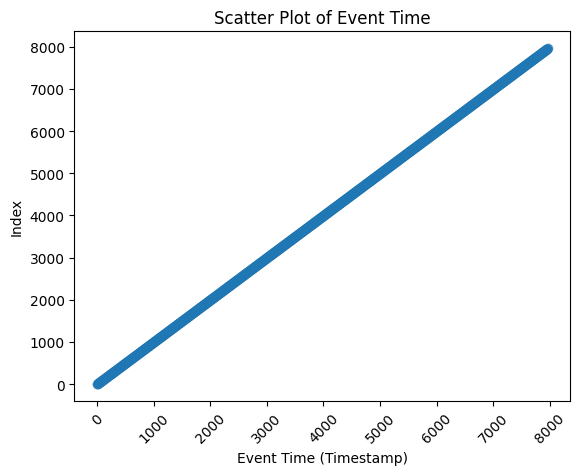

<Figure size 640x480 with 0 Axes>

In [14]:
event_time = X_tabular.index

plt.scatter(event_time, range(len(X_tabular)), alpha=0.1)
plt.xlabel("Event Time (Timestamp)")
plt.ylabel("Index")
plt.title("Scatter Plot of Event Time")
plt.xticks(rotation=45)
plt.show()
plt.tight_layout()

In [15]:
metadata['label'].value_counts()

label
Blip                   1821
Koi_Fish                706
Low_Frequency_Burst     621
Light_Modulation        512
Power_Line              449
Low_Frequency_Lines     447
Extremely_Loud          447
Scattered_Light         443
Violin_Mode             412
Scratchy                337
1080Lines               328
Whistle                 299
Helix                   279
Repeating_Blips         263
No_Glitch               150
Tomte                   103
1400Ripples              81
None_of_the_Above        81
Chirp                    60
Air_Compressor           58
Wandering_Line           42
Paired_Doves             27
Name: count, dtype: int64

In [16]:
# Compute autocorrelation for a specific lag using the index
lag = 0  # Change this for different lags
autocorr_value = X_tabular.index.to_series().autocorr(lag=lag)  # Access index as a series
print(f"Autocorrelation at lag {lag}: {autocorr_value}")

Autocorrelation at lag 0: 0.9999999999999998


In [17]:
y = X_tabular["label"].astype(int)
X_tabular = X_tabular.drop("label", axis=1)

KeyboardInterrupt: 

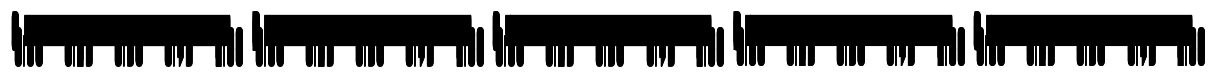

In [86]:
# import matplotlib.pyplot as plt
# import numpy as np
# import math
# import textwrap

# def plot_images_with_labels(images, labels, num_per_row=5, figsize=(15, 10), fontsize=8):
#     num_images = len(images)
#     num_rows = math.ceil(num_images / num_per_row)

#     fig, axes = plt.subplots(num_rows, num_per_row, figsize=figsize)
#     axes = axes.flatten()

#     for i in range(len(axes)):
#         if i < num_images:
#             axes[i].imshow(images[i], cmap='gray' if len(images[i].shape) == 2 else None)
#             wrapped_label = "\n".join(textwrap.wrap(str(labels[i]), width=10))  # Wrap long labels
#             axes[i].set_title(wrapped_label, fontsize=fontsize)
#         axes[i].axis("off")

#     plt.tight_layout()
#     plt.show()
    
# plot_images_with_labels(X_images,metadata['label'])

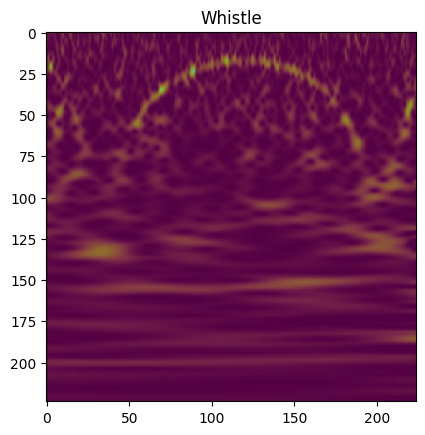

In [18]:
plt.title(metadata['label'][0])
plt.imshow(X_images[0])
plt.show()

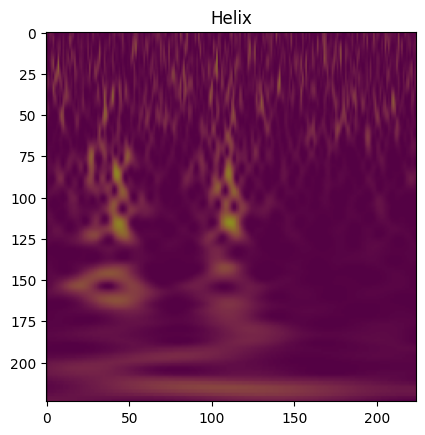

In [19]:
plt.title(metadata['label'][7962])
plt.imshow(X_images[7962])
plt.show()

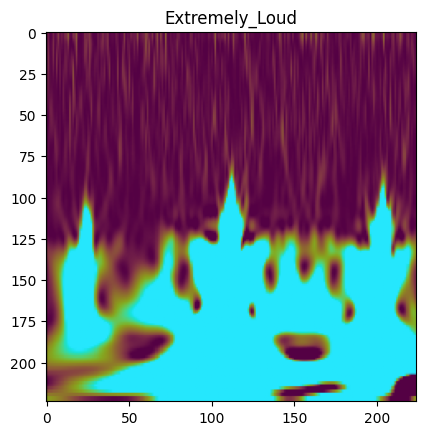

In [20]:
plt.title(metadata['label'][7961])
plt.imshow(X_images[7961])
plt.show()

# Deep Learning

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (BatchNormalization, Reshape,
                                     GlobalAveragePooling2D, Embedding, Bidirectional,Input,
                                     Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed, concatenate)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_hub as hub

# ViT feature Extractor

In [22]:
import tensorflow.keras.backend as K
K.clear_session()


In [ ]:
class ViTFeatureExtractor(tf.keras.Model):
    def __init__(self):
        super(ViTFeatureExtractor, self).__init__()
        self.vit_layer = hub.KerasLayer(
            "https://www.kaggle.com/models/spsayakpaul/vision-transformer/TensorFlow2/vit-b16-fe/1",
            trainable=False
        )
        self.flatten = layers.Flatten()  # Extracted features will be flattened

    def call(self, input_tensor):
        return self.flatten(self.vit_layer(input_tensor))
    
    

# Instantiate the model
vit_extractor = ViTFeatureExtractor()
# Extract features
X_image_features = vit_extractor.predict(X_images)
print("Extracted Image Feature Shape:", X_image_features.shape)


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.17.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a 

ModuleNotFoundError: No module named 'keras.src.engine'

In [24]:
# Convert to DataFrame if needed
X_image_features_df = pd.DataFrame(X_image_features)
X_image_features_df.columns = [f'img_feat_{i}' for i in range(X_image_features.shape[1])]

# Reset index to align with tabular data
X_tabular = X_tabular.reset_index(drop=True)
X_image_features_df = X_image_features_df.reset_index(drop=True)

# Concatenate tabular and image features
X_combined = pd.concat([X_tabular, X_image_features_df], axis=1)
print("Final Combined Feature Shape:", X_combined.shape)

Final Combined Feature Shape: (7966, 776)


In [25]:
random_states= [42,55,100,500,300]
index = 0
print(random_states[index])

42


In [26]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=random_states[index], stratify=y)

## Random Forest

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=random_states[index])
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [29]:
def evaluate_model(model, test_data,y_test,ann=False):
    y_true = y_test
    if ann:
        y_pred = np.argmax(model.predict(test_data),axis=1)
    else:
        y_pred = model.predict(test_data)
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    print(f'F1 Score: {f1:.4f}')
    print(f'Accuracy: {acc:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'Recall: {recall:.4f}')
    
    return {'Accuracy':acc,'F1 Score':f1,'Precision':prec,'Recall':recall}

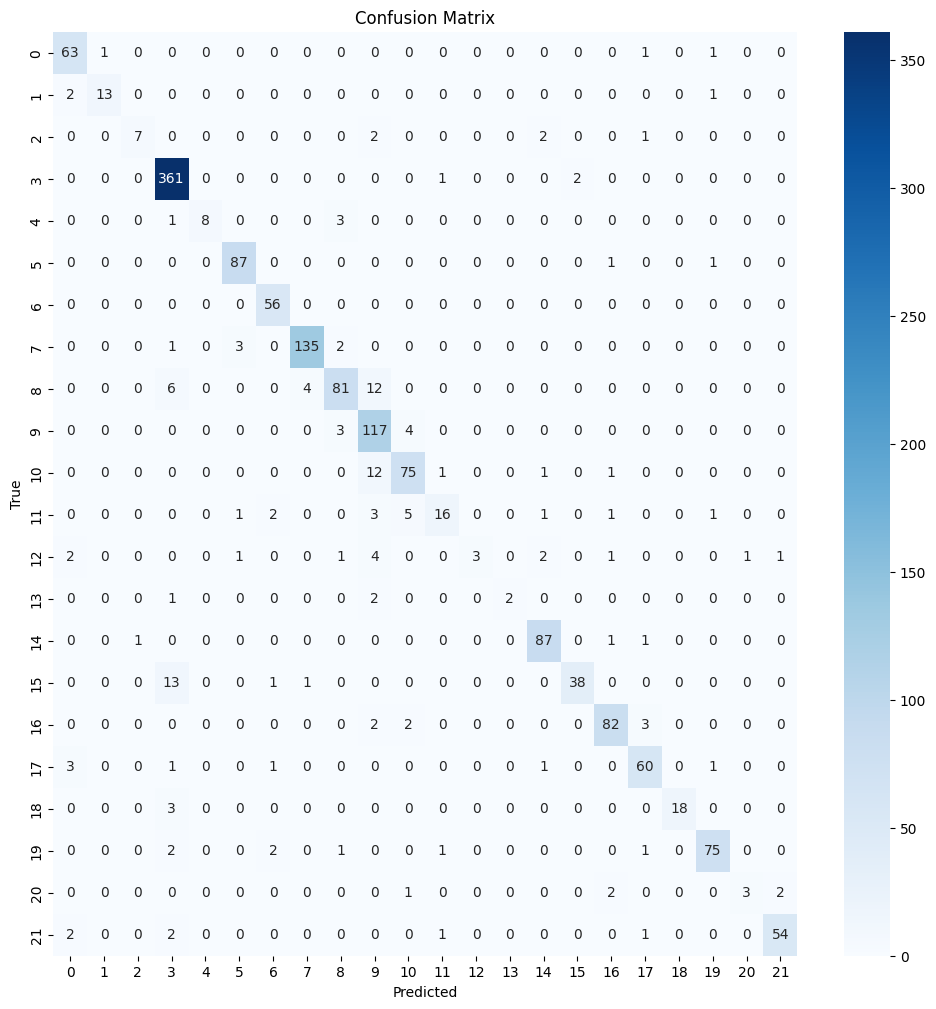

F1 Score: 0.8989
Accuracy: 0.9040
Precision: 0.9071
Recall: 0.9040


In [30]:
rf_metrics = evaluate_model(rf_model, X_test,y_test)

In [31]:
# vit_model.save("vit_model.h5")

## ANN

In [32]:
def plot_loss_curves(history):
    plt.figure(figsize=(10, 7))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 7))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.show()

In [33]:
early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor the validation loss
    patience=100,                # Wait for 10 epochs without improvement
    verbose=1,                 # Print a message when stopping
    restore_best_weights=True # Restore the best weights after stopping
)

In [34]:
num_classes = len(np.unique(y_train))

model_ANN = tf.keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_combined.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model_ANN.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)



c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
history_ANN = model_ANN.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=32,
    verbose=1,
    callbacks = [early_stopping]
)

Epoch 1/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2390 - loss: 28.0533 - val_accuracy: 0.5545 - val_loss: 2.4110
Epoch 2/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6123 - loss: 1.9542 - val_accuracy: 0.5694 - val_loss: 2.3740
Epoch 3/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6500 - loss: 1.5699 - val_accuracy: 0.7153 - val_loss: 1.3208
Epoch 4/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7409 - loss: 1.1483 - val_accuracy: 0.6894 - val_loss: 1.4256
Epoch 5/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7320 - loss: 1.1447 - val_accuracy: 0.6737 - val_loss: 1.7397
Epoch 6/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7557 - loss: 1.1990 - val_accuracy: 0.7953 - val_loss: 0.9063
Epoch 7/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7782 - loss: 0.9693 - val_accuracy: 0.7749 - val_loss: 1.0883
Epoch 8/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8144 - loss: 0.7316 -

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


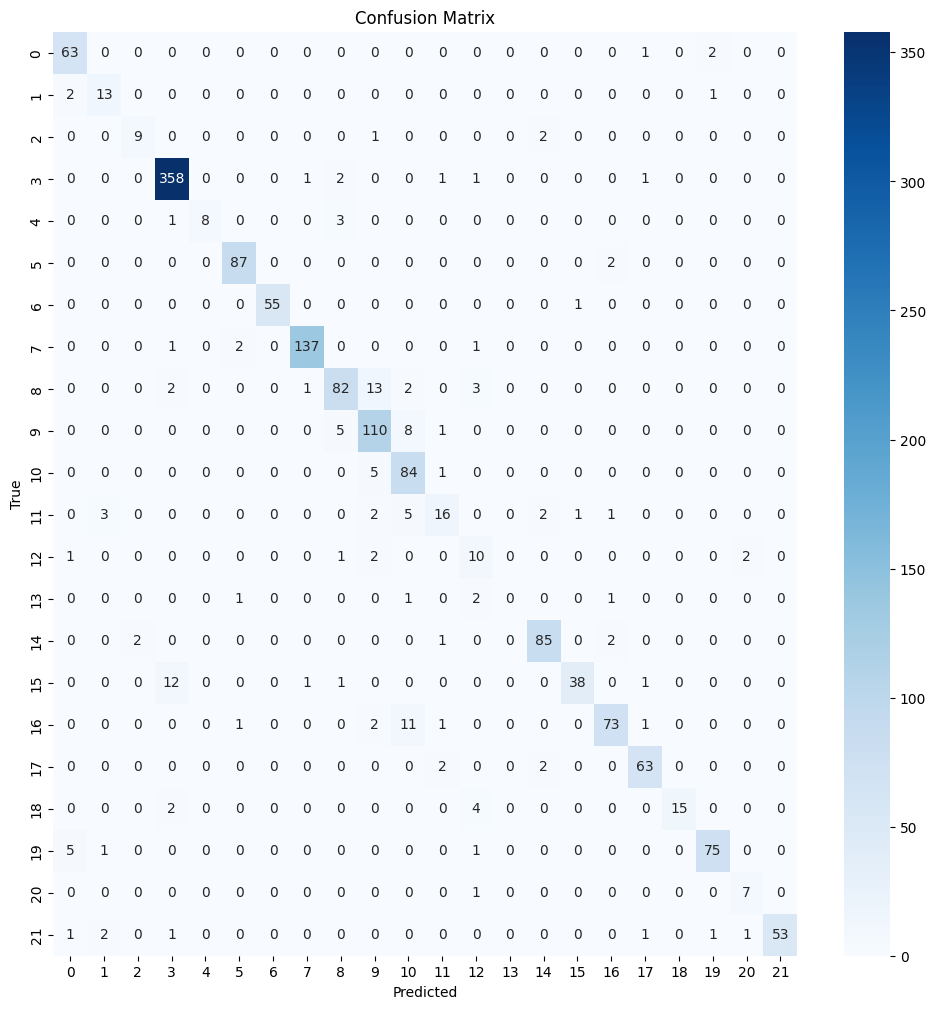

F1 Score: 0.9025
Accuracy: 0.9040
Precision: 0.9067
Recall: 0.9040


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [36]:
ann_metrics = evaluate_model(model_ANN, X_test,y_test,ann=True)

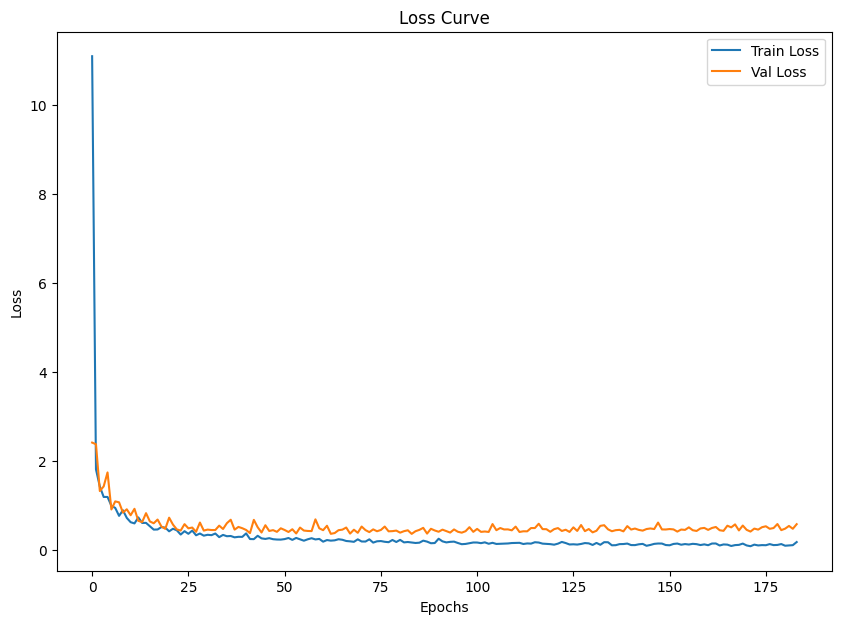

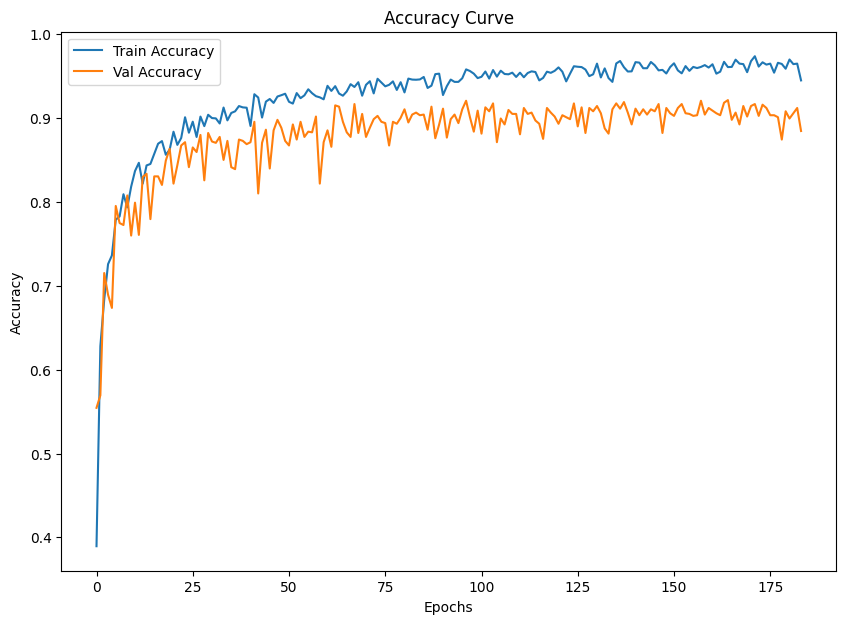

In [37]:
plot_loss_curves(history_ANN)

## XBoost


In [38]:
try:
    from xgboost import XGBClassifier
    XGB = XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', use_label_encoder=False)
except:
    pass

XGB.fit(X_train, y_train)


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [21:25:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softmax', ...)

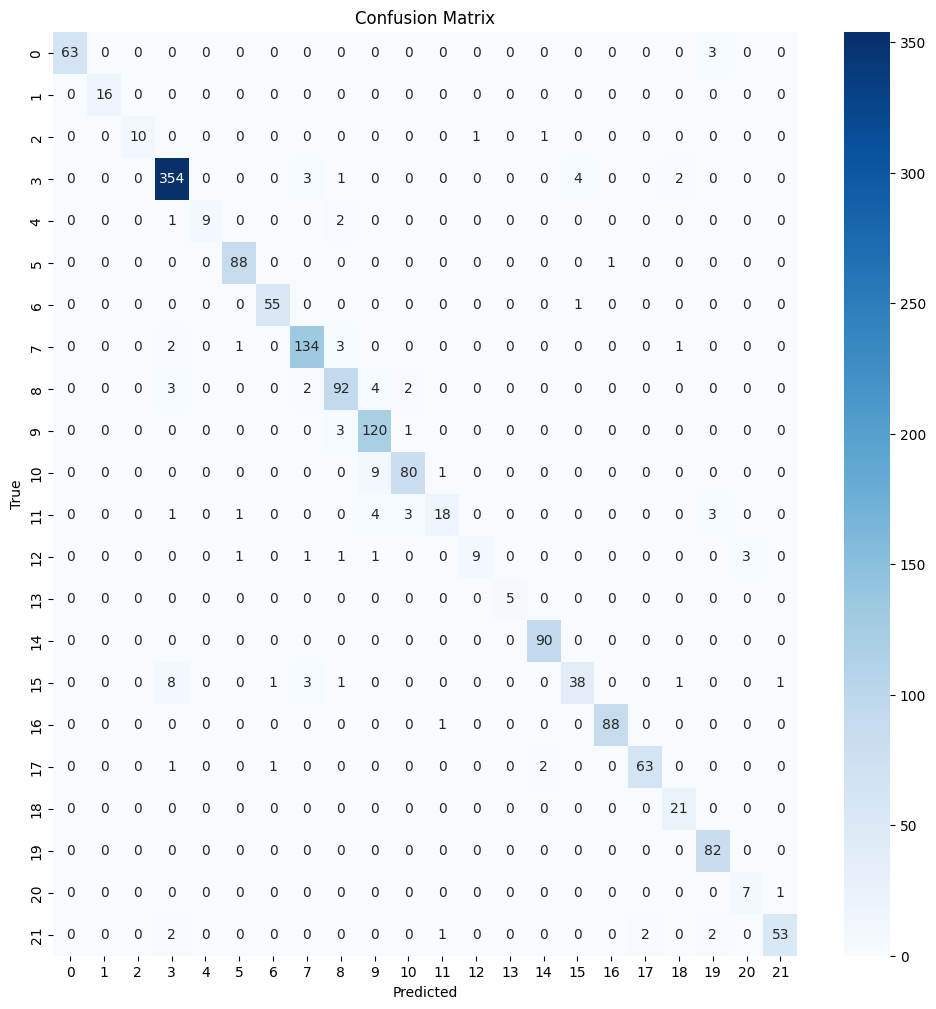

F1 Score: 0.9363
Accuracy: 0.9379
Precision: 0.9385
Recall: 0.9379


In [39]:
XGB_metrics = evaluate_model(XGB, X_test,y_test)

## Decision Tree

In [40]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier(random_state=random_states[index])

# Fit on training data
DT.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

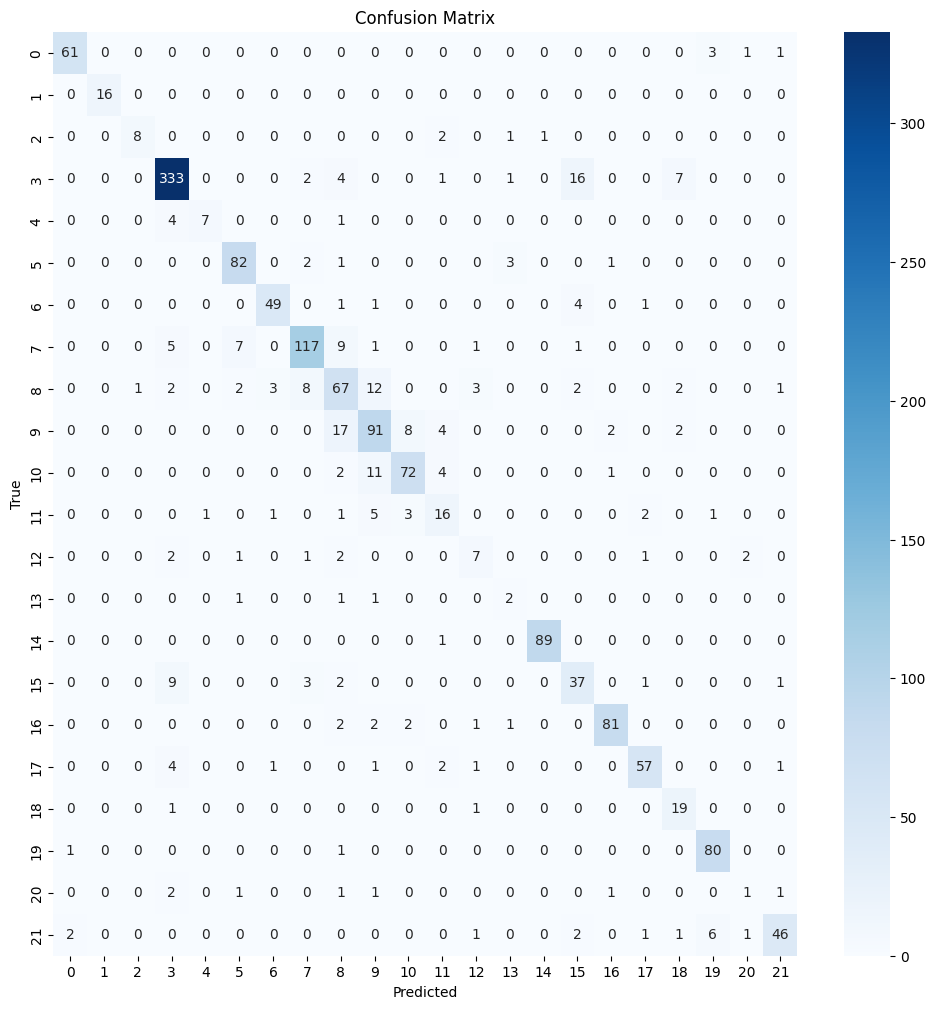

F1 Score: 0.8404
Accuracy: 0.8394
Precision: 0.8445
Recall: 0.8394


In [41]:
DT_metrics = evaluate_model(DT, X_test,y_test)

## SVM 

In [42]:
from sklearn.svm import SVC
SVM = SVC(probability=True, random_state=random_states[index])

In [43]:
SVM.fit(X_train, y_train)

SVC(probability=True, random_state=42)

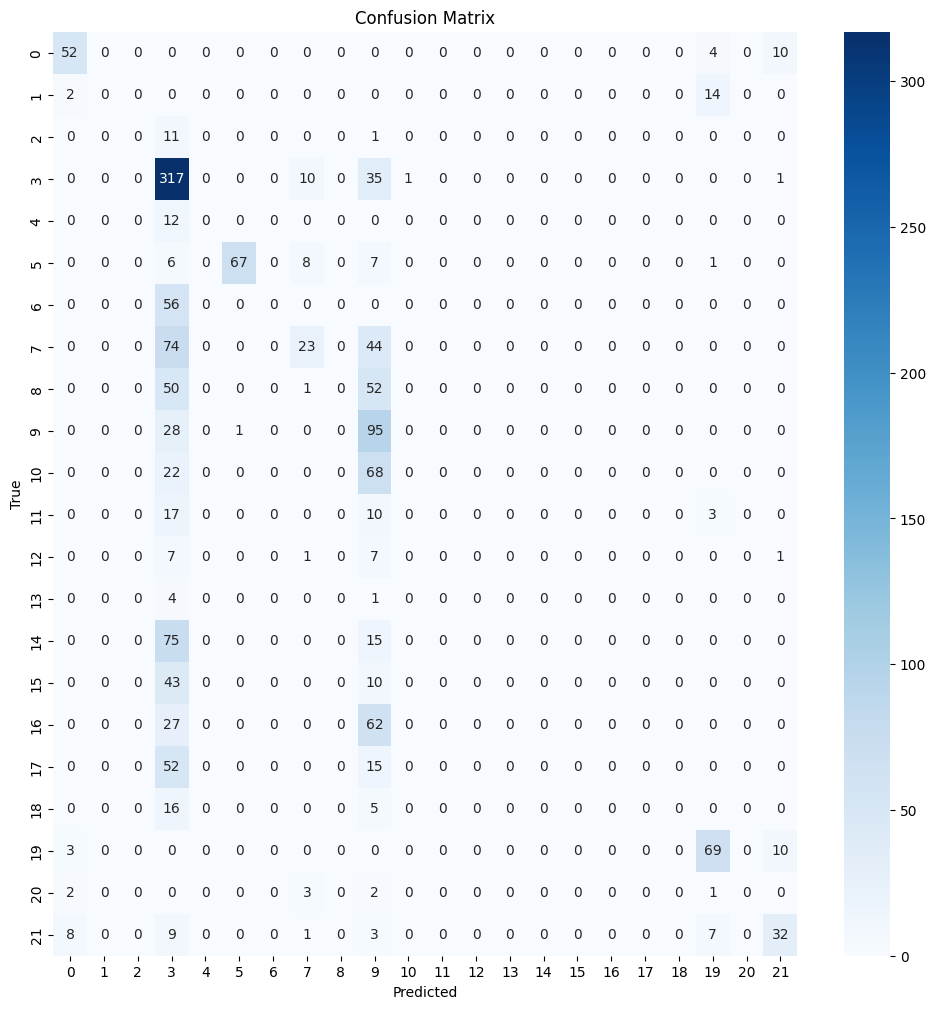

F1 Score: 0.3103
Accuracy: 0.4109
Precision: 0.2933
Recall: 0.4109


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [44]:
SVM_metrics = evaluate_model(SVM, X_test,y_test)

## ViT XAI

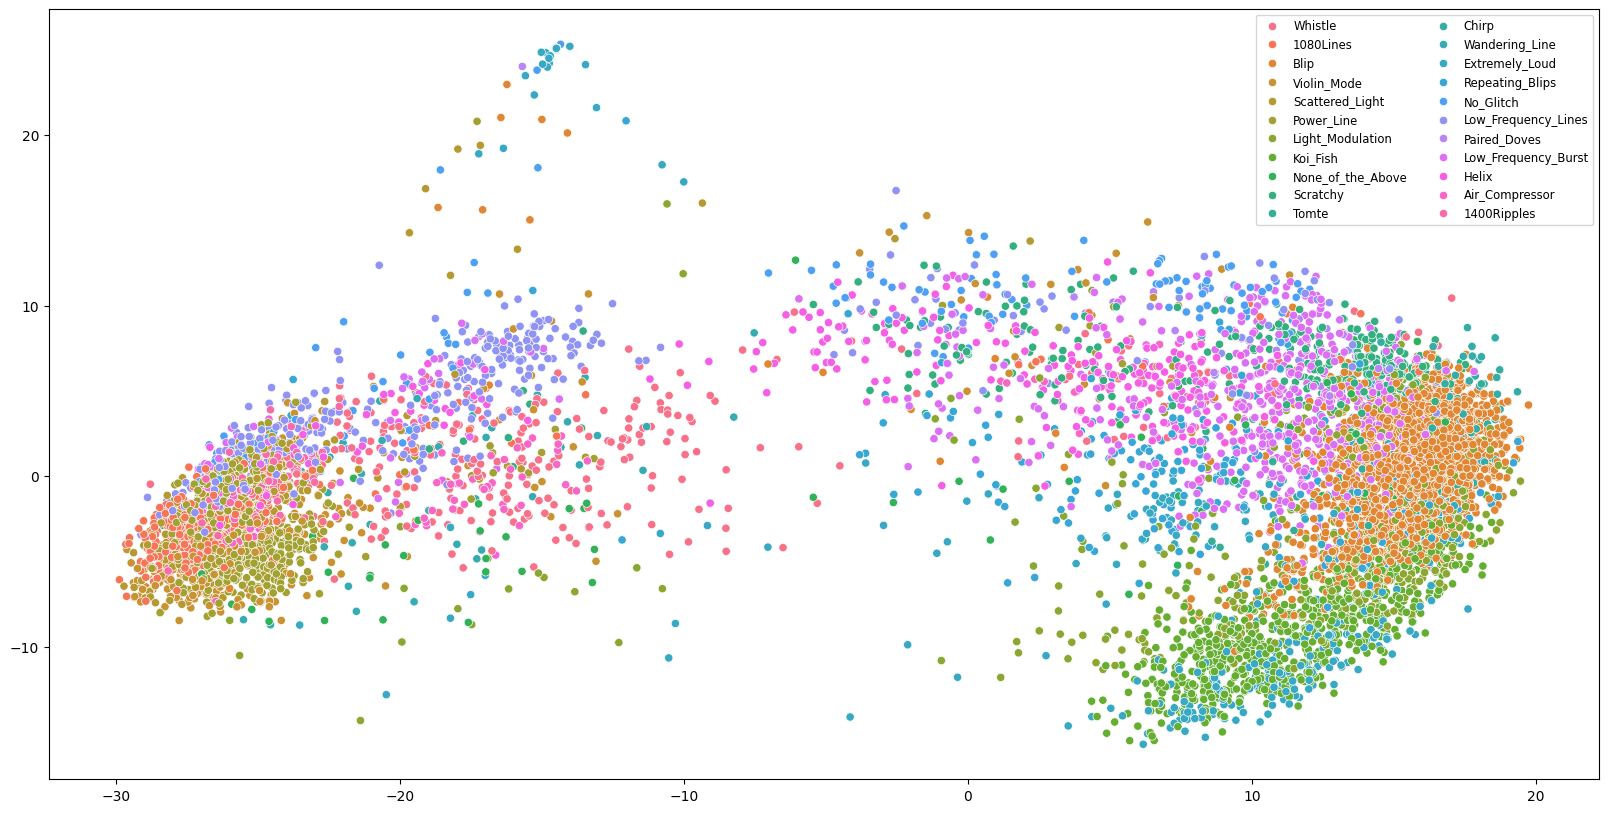

In [51]:
from sklearn.decomposition import PCA
plt.figure(figsize=(20,10))
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(X_image_features_df)
sns.scatterplot(x=reduced_features[:,0], y=reduced_features[:,1], hue=metadata['label'])
plt.legend(loc='upper right', fontsize='small', ncol=2)  # Smaller font and 2 columns


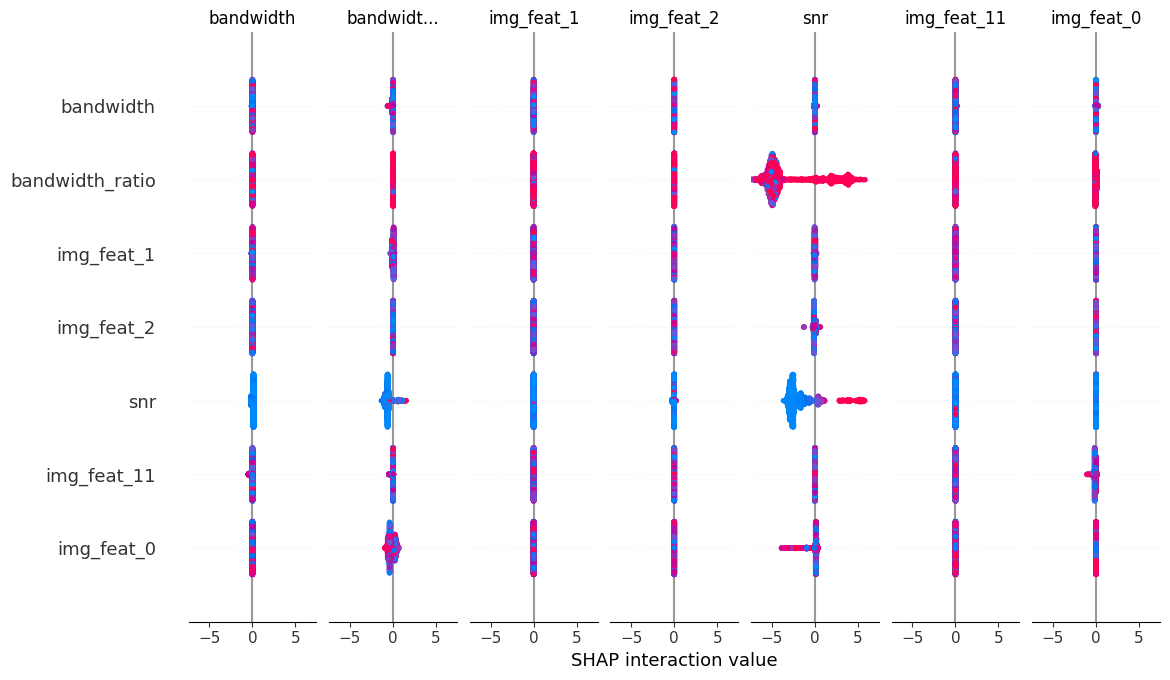

In [52]:
import shap

# For Random Forest/XGBoost
explainer = shap.TreeExplainer(XGB)  # or XGB
shap_values = explainer.shap_values(X_test)

# Global feature importance
shap.summary_plot(shap_values, X_test, feature_names=X_combined.columns)

In [53]:
label_encoder.classes_

array(['1080Lines', '1400Ripples', 'Air_Compressor', 'Blip', 'Chirp',
       'Extremely_Loud', 'Helix', 'Koi_Fish', 'Light_Modulation',
       'Low_Frequency_Burst', 'Low_Frequency_Lines', 'No_Glitch',
       'None_of_the_Above', 'Paired_Doves', 'Power_Line',
       'Repeating_Blips', 'Scattered_Light', 'Scratchy', 'Tomte',
       'Violin_Mode', 'Wandering_Line', 'Whistle'], dtype=object)

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treate

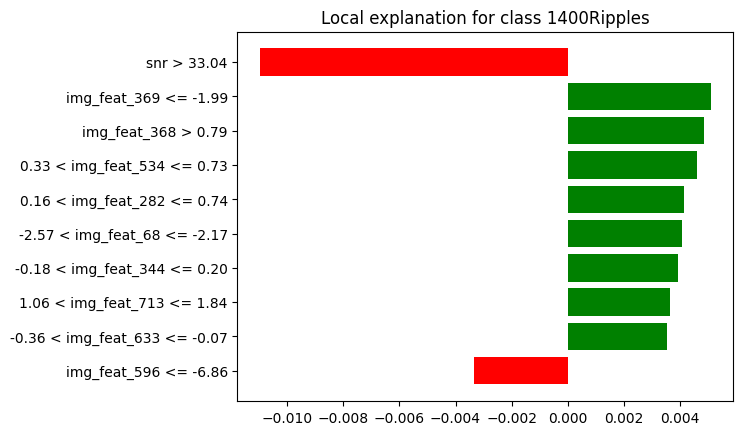

In [54]:
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    X_train.values, feature_names=X_combined.columns, class_names=label_encoder.classes_
)
exp = explainer.explain_instance(X_test.iloc[0], XGB.predict_proba, num_features=10)
exp.show_in_notebook()
fig = exp.as_pyplot_figure()
fig.savefig('lime_explanation.png', bbox_inches='tight', dpi=300)

# Collect the result

In [315]:
results = {
    "ANN (Advanced)": ann_metrics,
    "Random Forest": rf_metrics,
    "Decision Tree": DT_metrics,
    "Support Vector Machine":SVM_metrics
}
results["XGBoost"] = XGB_metrics

ViT_extractor_results = pd.DataFrame(results).T
print("==== Summary of All Models (ViT as a feature extractor) ====")
print(ViT_extractor_results)


==== Summary of All Models (ViT as a feature extractor) ====
                        Accuracy  F1 Score  Precision    Recall
ANN (Advanced)          0.919699  0.918987   0.922428  0.919699
Random Forest           0.916562  0.911420   0.914029  0.916562
Decision Tree           0.843789  0.840689   0.840170  0.843789
Support Vector Machine  0.420326  0.313419   0.289280  0.420326
XGBoost                 0.940402  0.938663   0.939360  0.940402


In [316]:
os.makedirs(f'random_states/random_state{random_states[index]}',exist_ok=True)

In [ ]:
# ViT_extractor_results.to_csv(f'random_states/random_state{random_states[index]}/ViT Extractor results.csv {random_states[index]}')

# Swin feature Extractor

In [50]:
import kagglehub

# Download latest version
path = kagglehub.model_download("spsayakpaul/swin/tensorFlow2/s3-tiny-224")

100%|██████████| 9.65k/9.65k [00:00<00:00, 10.3MB/s]


100%|██████████| 181k/181k [00:00<00:00, 427kB/s]

















100%|██████████| 15.1M/15.1M [00:17<00:00, 925kB/s]
100%|██████████| 108M/108M [00:37<00:00, 3.03MB/s]


In [51]:
path

'C:\\Users\\HP\\.cache\\kagglehub\\models\\spsayakpaul\\swin\\tensorFlow2\\s3-tiny-224\\1'

In [52]:
class SwinFeatureExtractor(tf.keras.Model):
    def __init__(self):
        super(SwinFeatureExtractor, self).__init__()
        # Load the Swin Transformer model
        self.swin_layer = hub.KerasLayer(
            path,
            trainable=False  # Set to True for fine-tuning
        )
        self.flatten = layers.Flatten()

    def call(self, input_tensor):
        swin_output = self.swin_layer(input_tensor)
        swin_output = self.flatten(swin_output)  # Flatten output
        return swin_output  # Return the extracted features
    
    # Instantiate the model
swin_extractor = SwinFeatureExtractor()
# Extract features
Swin_X_image_features = swin_extractor.predict(X_images)
print("Extracted Image Feature Shape:", Swin_X_image_features.shape)

249/249 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step
Extracted Image Feature Shape: (7966, 1000)


In [53]:
# Convert to DataFrame if needed
Swin_X_image_features_df = pd.DataFrame(Swin_X_image_features)
Swin_X_image_features_df.columns = [f'img_feat_{i}' for i in range(Swin_X_image_features.shape[1])]

# Reset index to align with tabular data
X_tabular = X_tabular.reset_index(drop=True)
Swin_X_image_features_df = Swin_X_image_features_df.reset_index(drop=True)

# Concatenate tabular and image features
X_combined_swin = pd.concat([X_tabular, Swin_X_image_features_df], axis=1)
print("Final Combined Feature Shape:", X_combined_swin.shape)

Final Combined Feature Shape: (7966, 1008)


In [337]:
random_states[index]

300

In [319]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined_swin, y, test_size=0.2, random_state=random_states[index], stratify=y)

## Random Forest

In [320]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=random_states[index])
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=300)

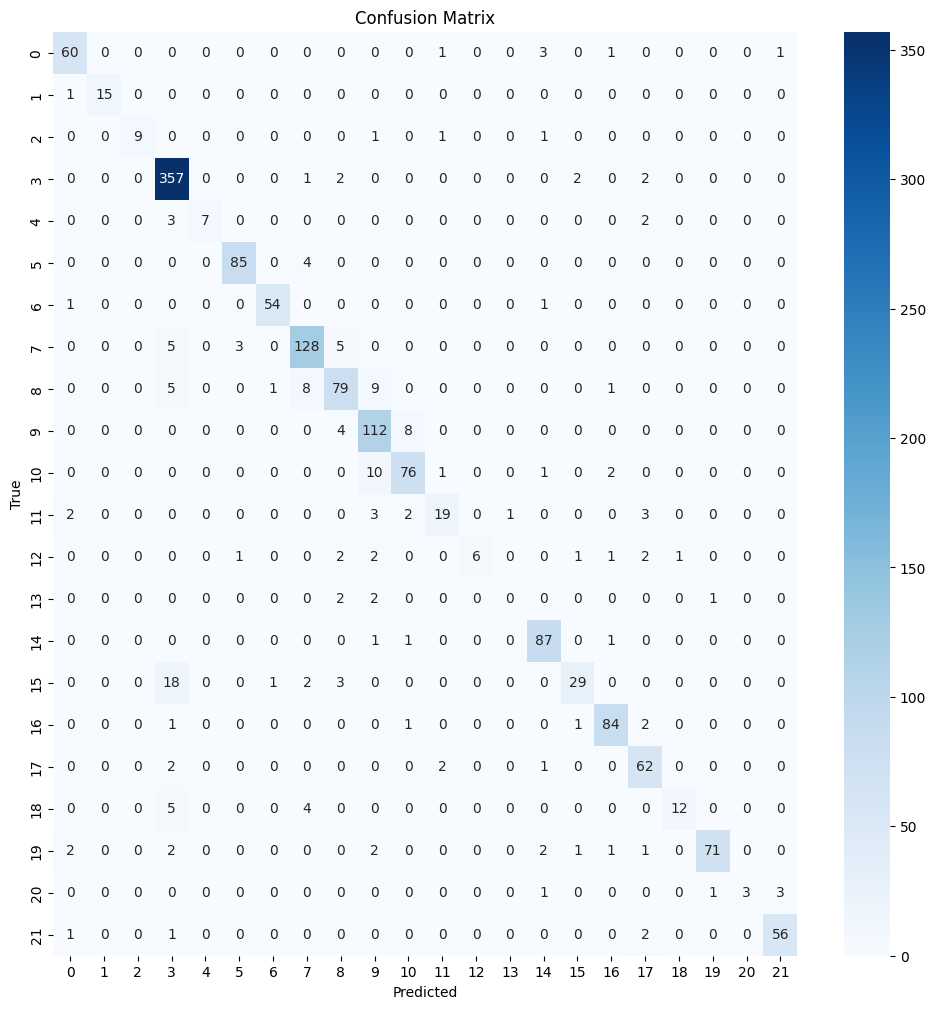

F1 Score: 0.8796
Accuracy: 0.8852
Precision: 0.8856
Recall: 0.8852


In [321]:
rf_metrics = evaluate_model(rf_model, X_test,y_test)

## ANN

In [322]:
def plot_loss_curves(history):
    plt.figure(figsize=(10, 7))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 7))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.show()

In [323]:
early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor the validation loss
    patience=100,                # Wait for 10 epochs without improvement
    verbose=1,                 # Print a message when stopping
    restore_best_weights=True # Restore the best weights after stopping
)

In [324]:
num_classes = len(np.unique(y_train))

model_ANN = tf.keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_combined_swin.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model_ANN.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)



c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [325]:
history_ANN = model_ANN.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=32,
    verbose=1,
    callbacks = [early_stopping]
)

Epoch 1/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2153 - loss: 27.3585 - val_accuracy: 0.5090 - val_loss: 2.0056
Epoch 2/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5595 - loss: 1.9114 - val_accuracy: 0.6008 - val_loss: 1.5102
Epoch 3/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6351 - loss: 1.3972 - val_accuracy: 0.5467 - val_loss: 2.1571
Epoch 4/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6572 - loss: 1.3868 - val_accuracy: 0.6847 - val_loss: 1.1237
Epoch 5/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7128 - loss: 1.0451 - val_accuracy: 0.7522 - val_loss: 1.0567
Epoch 6/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7143 - loss: 1.0181 - val_accuracy: 0.7788 - val_loss: 0.8960
Epoch 7/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7372 - loss: 0.9650 - val_accuracy: 0.7851 - val_loss: 0.7188
Epoch 8/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8063 - loss: 0.6790 -

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


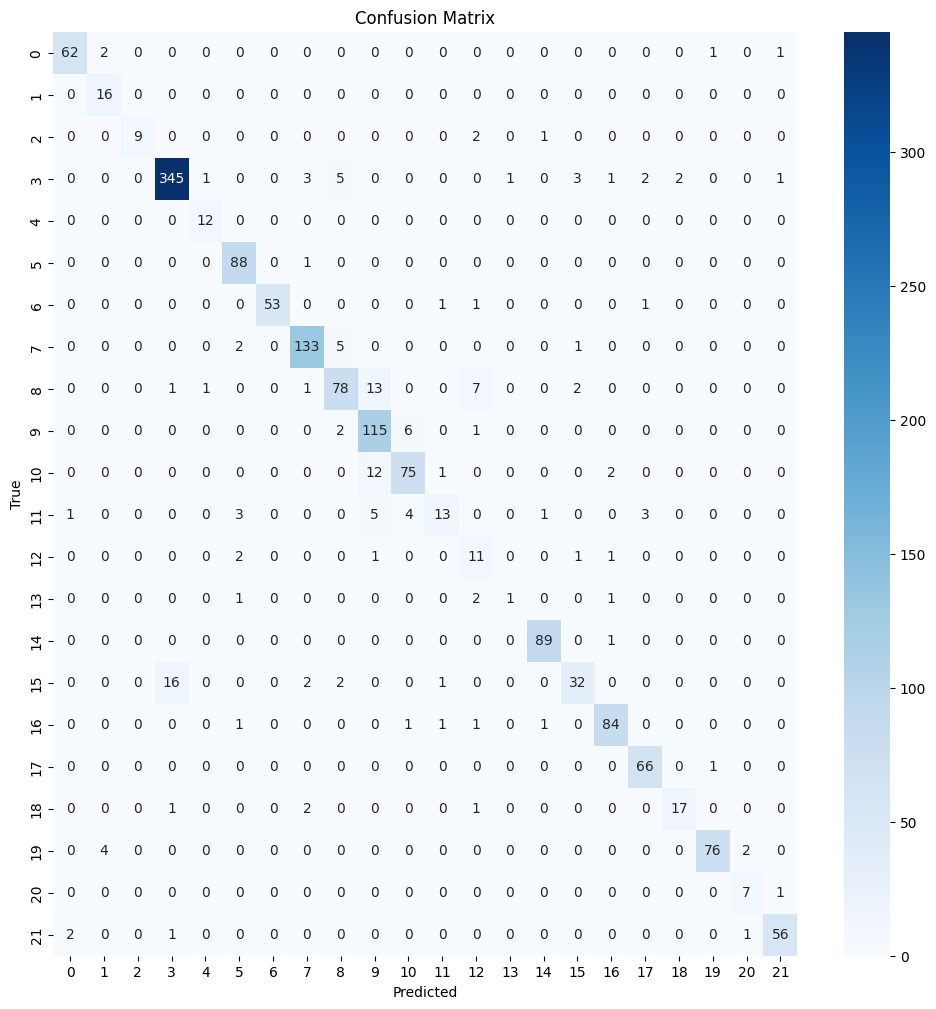

F1 Score: 0.9003
Accuracy: 0.9021
Precision: 0.9050
Recall: 0.9021


In [326]:
ann_metrics = evaluate_model(model_ANN, X_test,y_test,ann=True)

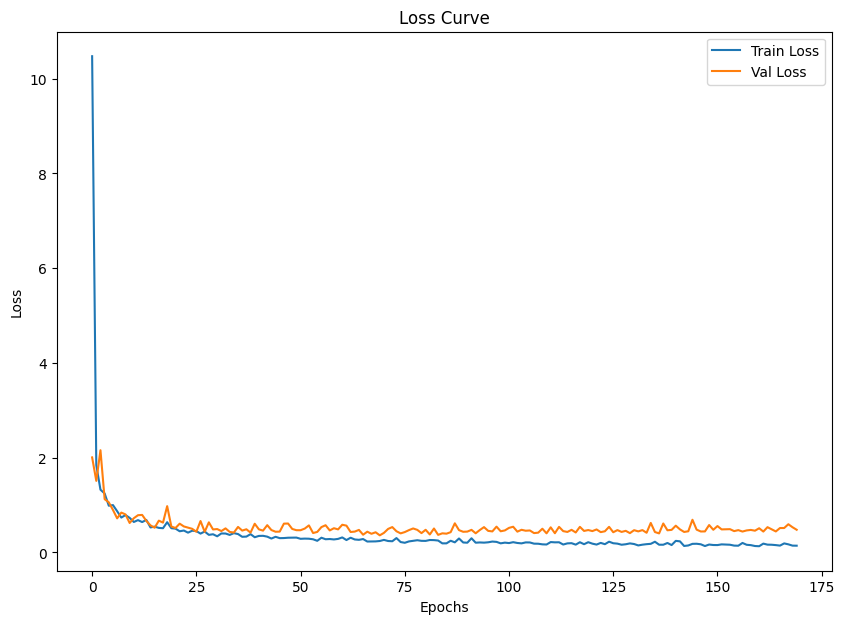

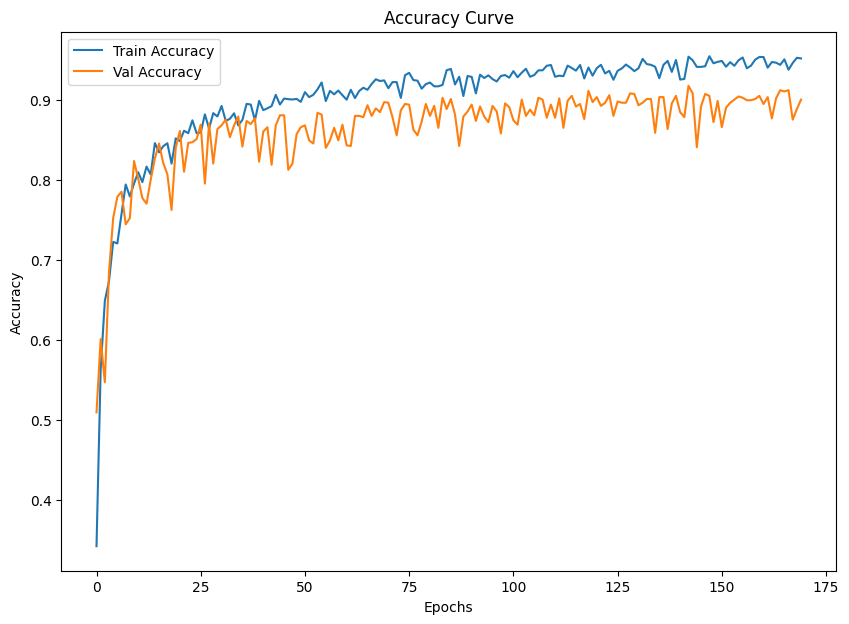

In [327]:
plot_loss_curves(history_ANN)

## XBoost


In [328]:
try:
    from xgboost import XGBClassifier
    XGB = XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', use_label_encoder=False)
except:
    pass

XGB.fit(X_train, y_train)

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [16:16:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softmax', ...)

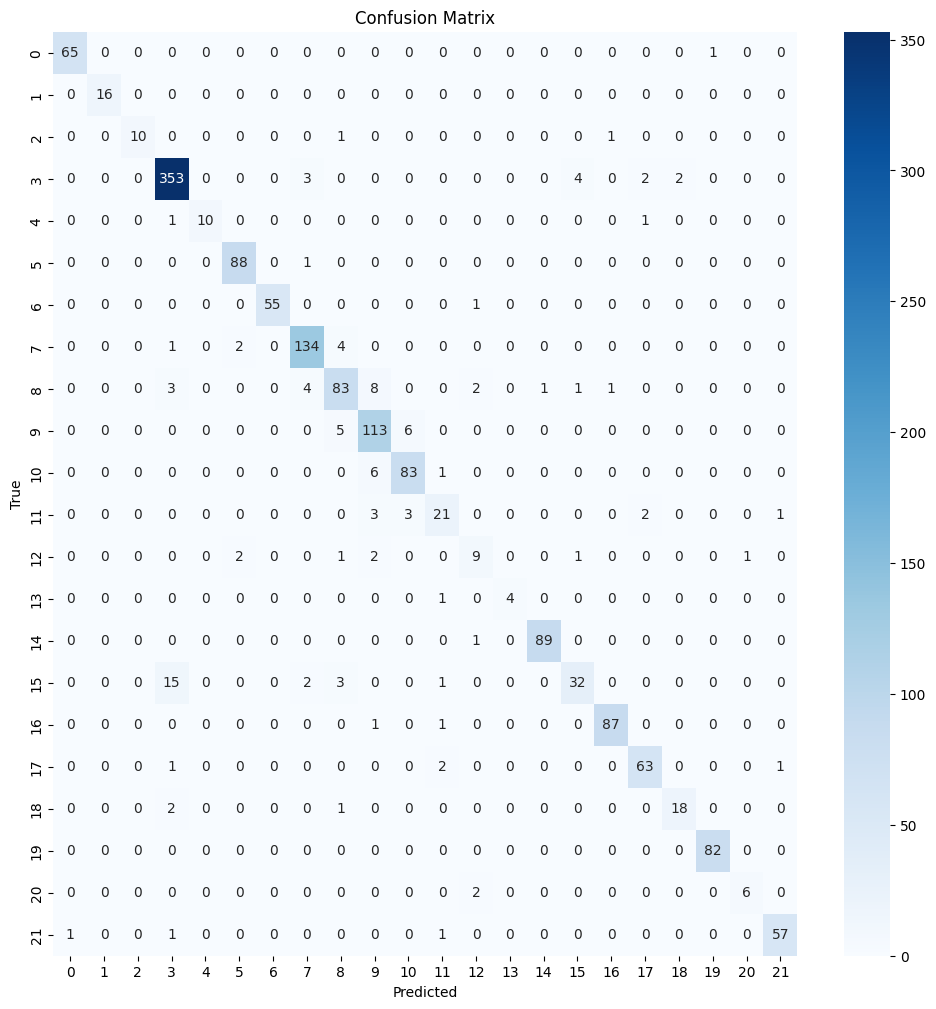

F1 Score: 0.9257
Accuracy: 0.9272
Precision: 0.9263
Recall: 0.9272


In [329]:
XGB_metrics = evaluate_model(XGB, X_test,y_test)

## Decision Tree

In [330]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier(random_state=random_states[index])

# Fit on training data
DT.fit(X_train, y_train)

DecisionTreeClassifier(random_state=300)

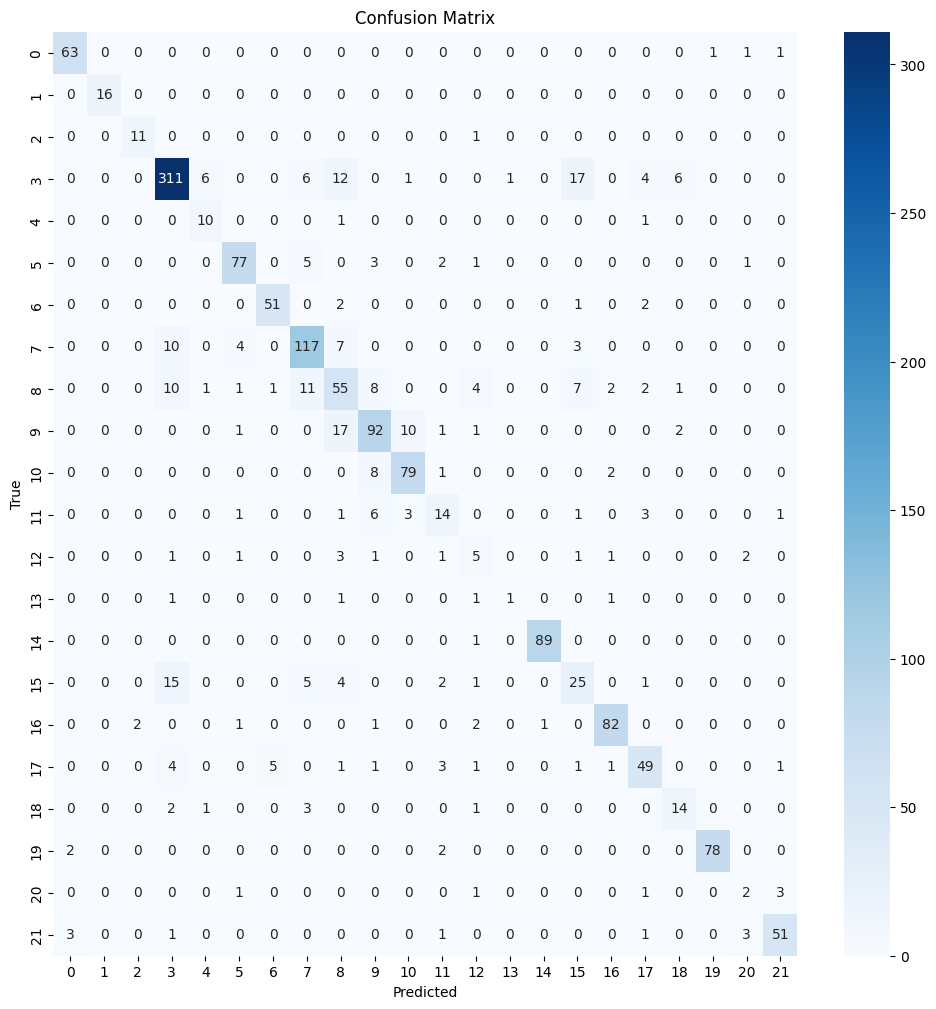

F1 Score: 0.8115
Accuracy: 0.8105
Precision: 0.8138
Recall: 0.8105


In [331]:
DT_metrics = evaluate_model(DT, X_test,y_test)

## SVM 

In [332]:
from sklearn.svm import SVC
SVM = SVC(probability=True, random_state=random_states[index])


In [333]:
SVM.fit(X_train, y_train)

SVC(probability=True, random_state=300)

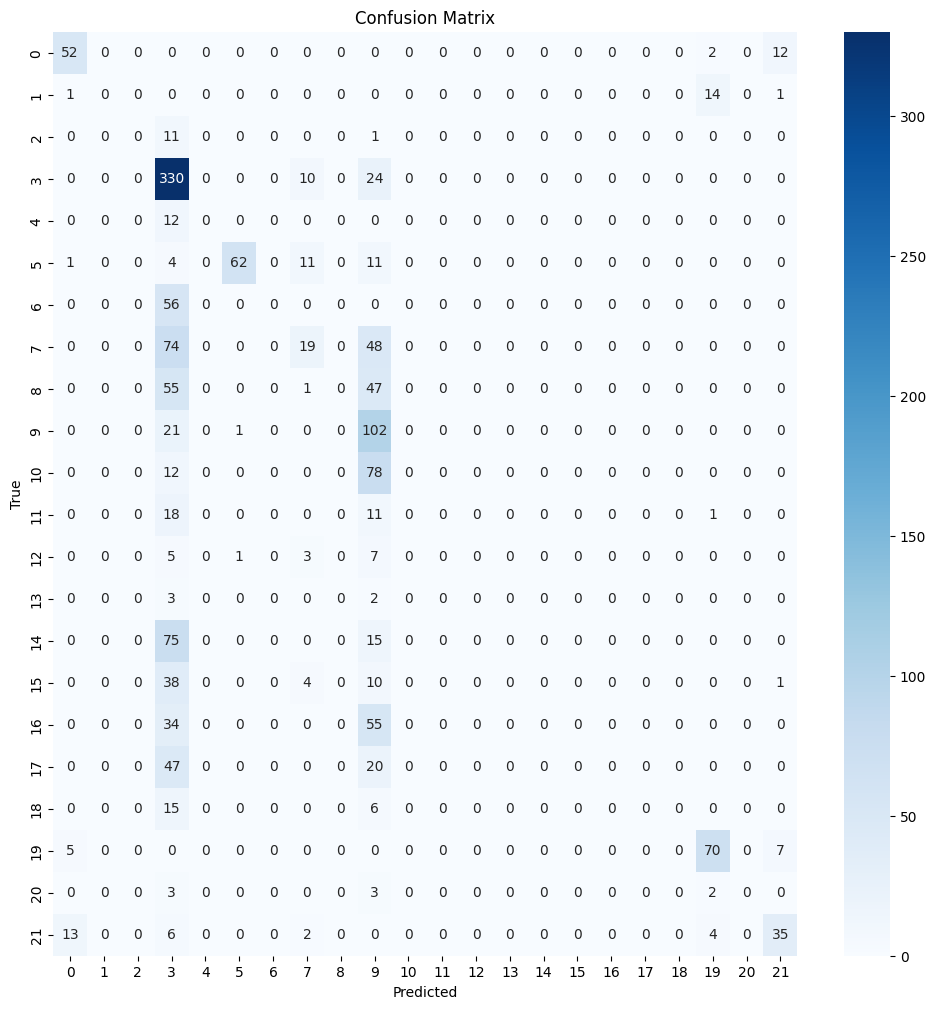

F1 Score: 0.3135
Accuracy: 0.4203
Precision: 0.2899
Recall: 0.4203


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [334]:
SVM_metrics = evaluate_model(SVM, X_test,y_test)

# Collect the result

In [335]:
results = {
    "ANN (Advanced)": ann_metrics,
    "Random Forest": rf_metrics,
    "Decision Tree": DT_metrics,
    "Support Vector Machine":SVM_metrics
}

results["XGBoost"] = XGB_metrics

Swin_extractor_results = pd.DataFrame(results).T
print("==== Summary of All Models (Swin as a feature extractor) ====")
print(Swin_extractor_results)


==== Summary of All Models (Swin as a feature extractor) ====
                        Accuracy  F1 Score  Precision    Recall
ANN (Advanced)          0.902133  0.900341   0.905050  0.902133
Random Forest           0.885194  0.879644   0.885576  0.885194
Decision Tree           0.810540  0.811479   0.813777  0.810540
Support Vector Machine  0.420326  0.313461   0.289898  0.420326
XGBoost                 0.927227  0.925681   0.926280  0.927227


In [336]:
Swin_extractor_results.to_csv(f'random_states/random_state{random_states[index]}/Swin Extractor results.csv {random_states[index]}')

# CV Results calculating

## ViT

In [340]:
print(random_states)
ViT_tables = [pd.read_csv(f'random_states/random_state{random_state}/ViT Extractor results.csv {random_state}').set_index('Unnamed: 0') for random_state in tqdm(random_states)]

ViT_tables


[42, 55, 100, 500, 300]


100%|██████████| 5/5 [00:00<00:00, 112.36it/s]


[                        Accuracy  F1 Score  Precision    Recall
 Unnamed: 0                                                     
 ANN (Advanced)          0.897742  0.895296   0.899362  0.897742
 Random Forest           0.904015  0.898899   0.907054  0.904015
 Decision Tree           0.839398  0.840393   0.844466  0.839398
 Support Vector Machine  0.410916  0.310275   0.293341  0.410916
 XGBoost                 0.937892  0.936253   0.938467  0.937892,
                         Accuracy  F1 Score  Precision    Recall
 Unnamed: 0                                                     
 ANN (Advanced)          0.917189  0.913706   0.916961  0.917189
 Random Forest           0.907152  0.900165   0.905597  0.907152
 Decision Tree           0.858846  0.859652   0.862956  0.858846
 Support Vector Machine  0.422208  0.317680   0.299163  0.422208
 XGBoost                 0.951694  0.950666   0.951596  0.951694,
                         Accuracy  F1 Score  Precision    Recall
 Unnamed: 0            

In [345]:

# Ensure the columns (metrics) and indices (models) are consistent
metrics = ViT_tables[0].columns
models = ViT_tables[0].index

# Initialize an empty DataFrame for the final table
ViT_final_table = pd.DataFrame(index=models, columns=metrics)
# Compute mean ± std for each model and metric
for model in models:
    for metric in metrics:
        # Collect values across all datasets
        values = [ds.loc[model, metric] for ds in ViT_tables]
        
        # Calculate mean and standard deviation
        mean = np.mean(values)
        std = np.std(values)
        
        # Format as "mean ± std"
        ViT_final_table.loc[model, metric] = f"{mean*100:.2f} ± {std:.2f}"
        
ViT_final_table.head()

Accuracy      F1 Score     Precision        Recall
Unnamed: 0                                                                    
ANN (Advanced)          91.20 ± 0.01  90.98 ± 0.01  91.27 ± 0.01  91.20 ± 0.01
Random Forest           90.97 ± 0.00  90.41 ± 0.00  90.92 ± 0.00  90.97 ± 0.00
Decision Tree           85.19 ± 0.01  85.17 ± 0.01  85.39 ± 0.01  85.19 ± 0.01
Support Vector Machine  41.47 ± 0.01  31.09 ± 0.00  29.54 ± 0.00  41.47 ± 0.01
XGBoost                 94.40 ± 0.01  94.25 ± 0.01  94.37 ± 0.01  94.40 ± 0.01

In [346]:
ViT_final_table.to_csv('5Fold final results for ML models and ViT features extractor.csv')

## Swin

In [347]:
print(random_states)
Swin_tables = [pd.read_csv(f'random_states/random_state{random_state}/Swin Extractor results.csv {random_state}').set_index('Unnamed: 0') for random_state in tqdm(random_states)]

Swin_tables


[42, 55, 100, 500, 300]


100%|██████████| 5/5 [00:00<00:00, 106.34it/s]


[                        Accuracy  F1 Score  Precision    Recall
 Unnamed: 0                                                     
 ANN (Advanced)          0.890213  0.888423   0.894486  0.890213
 Random Forest           0.881430  0.875521   0.882209  0.881430
 Decision Tree           0.829987  0.829617   0.831979  0.829987
 Support Vector Machine  0.410916  0.310167   0.293209  0.410916
 XGBoost                 0.926600  0.924825   0.926386  0.926600,
                         Accuracy  F1 Score  Precision    Recall
 Unnamed: 0                                                     
 ANN (Advanced)          0.903388  0.902201   0.905475  0.903388
 Random Forest           0.890841  0.884765   0.891530  0.890841
 Decision Tree           0.854454  0.855842   0.859040  0.854454
 Support Vector Machine  0.422208  0.317680   0.299163  0.422208
 XGBoost                 0.949812  0.948356   0.949858  0.949812,
                         Accuracy  F1 Score  Precision    Recall
 Unnamed: 0            

In [348]:

# Ensure the columns (metrics) and indices (models) are consistent
metrics = Swin_tables[0].columns
models = Swin_tables[0].index

# Initialize an empty DataFrame for the final table
Swin_final_table = pd.DataFrame(index=models, columns=metrics)
# Compute mean ± std for each model and metric
for model in models:
    for metric in metrics:
        # Collect values across all datasets
        values = [ds.loc[model, metric] for ds in Swin_tables]
        
        # Calculate mean and standard deviation
        mean = np.mean(values)
        std = np.std(values)
        
        # Format as "mean ± std"
        Swin_final_table.loc[model, metric] = f"{mean*100:.2f} ± {std:.2f}"
        
Swin_final_table.head()

Accuracy      F1 Score     Precision        Recall
Unnamed: 0                                                                    
ANN (Advanced)          89.41 ± 0.01  89.24 ± 0.01  89.75 ± 0.01  89.41 ± 0.01
Random Forest           88.58 ± 0.00  88.01 ± 0.00  88.68 ± 0.00  88.58 ± 0.00
Decision Tree           83.40 ± 0.01  83.49 ± 0.01  83.81 ± 0.01  83.40 ± 0.01
Support Vector Machine  41.47 ± 0.01  31.09 ± 0.00  29.55 ± 0.00  41.47 ± 0.01
XGBoost                 93.12 ± 0.01  92.94 ± 0.01  93.05 ± 0.01  93.12 ± 0.01

In [349]:
Swin_final_table.to_csv('5Fold final results for ML models and Swin features extractor.csv')